In [30]:
# from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
from matplotlib import pyplot as plt

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format
# tf.keras.backend.set_floatx('float32')

print("Ran the import statements.")

Ran the import statements.


In [31]:
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")
train_df = train_df.reindex(np.random.permutation(train_df.index)) # shuffle the training set

In [32]:
# Calculate the Z-scores of each column in the training set and
# write those Z-scores into a new pandas DataFrame named train_df_norm.
train_df_mean = train_df.mean()
train_df_std = train_df.std()
train_df_norm = (train_df - train_df_mean)/train_df_std

# Examine some of the values of the normalized training set. Notice that most 
# Z-scores fall between -2 and +2.
train_df_norm.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
3054,0.9,0.0,-0.8,-0.7,-0.6,-0.7,-0.6,-1.0,-1.3
6403,0.6,-0.8,0.8,-0.5,-0.4,-0.2,-0.4,-1.1,-0.9
12323,-1.0,1.4,0.6,-0.9,-0.9,-0.9,-0.9,-0.9,-1.0
6263,0.7,-0.7,1.9,0.2,0.5,0.3,0.5,-0.4,-0.2
3360,0.8,-0.8,-0.9,1.6,0.8,1.2,0.9,2.0,0.9


In [33]:
# Calculate the Z-scores of each column in the test set and
# write those Z-scores into a new pandas DataFrame named test_df_norm.
test_df_mean = test_df.mean()
test_df_std  = test_df.std()
test_df_norm = (test_df - test_df_mean)/test_df_std

In [34]:
threshold = 265000 # This is the 75th percentile for median house values.
train_df_norm["median_house_value_is_high"] = (train_df_norm["median_house_value"] > threshold).astype(float)
test_df_norm["median_house_value_is_high"] = (test_df_norm["median_house_value"] > threshold).astype(float)

# Print out a few example cells from the beginning and 
# middle of the training set, just to make sure that
# your code created only 0s and 1s in the newly created
# median_house_value_is_high column
train_df_norm["median_house_value_is_high"].head(8000)

3054    0.0
6403    0.0
12323   0.0
6263    0.0
3360    0.0
         ..
11312   0.0
7890    0.0
11668   0.0
12847   0.0
16266   0.0
Name: median_house_value_is_high, Length: 8000, dtype: float64

In [35]:
# Create an empty list that will eventually hold all created feature columns.
feature_columns = []

# Create a numerical feature column to represent median_income.
median_income = tf.feature_column.numeric_column("median_income")
feature_columns.append(median_income)

# Create a numerical feature column to represent total_rooms.
tr = tf.feature_column.numeric_column("total_rooms")
feature_columns.append(tr)

# Convert the list of feature columns into a layer that will later be fed into
# the model. 
feature_layer = layers.DenseFeatures(feature_columns)

# Print the first 3 and last 3 rows of the feature_layer's output when applied
# to train_df_norm:
feature_layer(dict(train_df_norm))

<tf.Tensor: shape=(17000, 2), dtype=float32, numpy=
array([[-1.0403644 , -0.6971107 ],
       [-1.1355872 , -0.5053629 ],
       [-0.88068146, -0.93152004],
       ...,
       [-0.42170444, -0.10948174],
       [ 0.40045032, -0.27278847],
       [-1.1934441 , -0.13379426]], dtype=float32)>

In [36]:
#@title Define the functions that create and train a model.
def create_model(my_learning_rate, feature_layer, my_metrics):
  """Create and compile a simple classification model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the feature layer (the list of features and how they are represented)
  # to the model.
  model.add(feature_layer)

  # Funnel the regression value through a sigmoid function.
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                  activation=tf.sigmoid),)

  # Call the compile method to construct the layers into a model that
  # TensorFlow can execute.  Notice that we're using a different loss
  # function for classification than for regression.    
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)

  return model        


def train_model(model, dataset, epochs, label_name,
                batch_size=None, shuffle=True):
  """Feed a dataset into the model in order to train it."""

  # The x parameter of tf.keras.Model.fit can be a list of arrays, where
  # each array contains the data for one feature.  Here, we're passing
  # every column in the dataset. Note that the feature_layer will filter
  # away most of those columns, leaving only the desired columns and their
  # representations as features.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name)) 
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle)
  
  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch

  # Isolate the classification metric for each epoch.
  hist = pd.DataFrame(history.history)

  return epochs, hist  

print("Defined the create_model and train_model functions.")   

Defined the create_model and train_model functions.


In [37]:
#@title Define the plotting function.
def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""  
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

print("Defined the plot_curve function.")

Defined the plot_curve function.


Epoch 1/20
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
170/170 [==============================] - 0s 2ms/step - loss: 0.6759 - accuracy: 0.7211
Epoch 2/20
170/170 [==============================] - 0s 2ms/step - loss: 0.5852 - accuracy: 0.8690
Epoch 3/20
170/170 [==============================] - 0s 2ms/step - loss: 0.5067 - accuracy: 0.9668
Epoch 4/20
170/170 [==============================] - 0s 1ms/step - loss: 0.4393 - accuracy: 0.9974: 0s - loss: 0.4471 - accuracy: 0.
Epoch 5/20
170/170 [==============================] - 0s 1ms/step - loss: 0.3813 - accuracy: 1.0000
Epoch 6/20
170/170 [==============================] - 0s 1ms/step - loss: 0.3305 - accuracy: 1.0000
Epoch 7/20
170/170 [==============================] - 0s 1ms/step - loss: 0.2858 - accuracy: 1.0000
Epoch 8/20
170/170 [==============================] - 0s 1ms/step - loss: 0.2464 - accuracy: 1.0000
Epoch 9/20
170/170 [==============================] - 0s

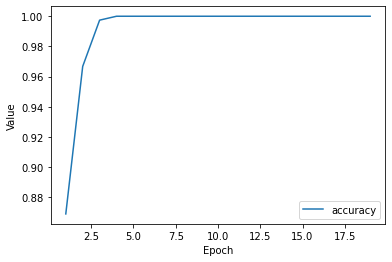

In [43]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
label_name = "median_house_value_is_high"
classification_threshold = 0.52

# Establish the metrics the model will measure.
METRICS = [
           tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                           threshold=classification_threshold),
          ]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

# Plot a graph of the metric(s) vs. epochs.
list_of_metrics_to_plot = ['accuracy'] 

plot_curve(epochs, hist, list_of_metrics_to_plot)

In [44]:
features = {name:np.array(value) for name, value in test_df_norm.items()}
label = np.array(features.pop(label_name))

my_model.evaluate(x = features, y = label, batch_size=batch_size)

Consider rewriting this model with the Functional API.
30/30 [==============================] - 0s 1ms/step - loss: 0.0333 - accuracy: 1.0000


[0.03333272412419319, 1.0]

Epoch 1/20
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
170/170 [==============================] - 0s 2ms/step - loss: 0.6580 - accuracy: 0.7791 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/20
170/170 [==============================] - 0s 2ms/step - loss: 0.5743 - accuracy: 0.9771 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/20
170/170 [==============================] - 0s 2ms/step - loss: 0.5017 - accuracy: 0.9985 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/20
170/170 [==============================] - 0s 1ms/step - loss: 0.4378 - accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00A: 0s - loss: 0.4475 - accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+
Epoch 5/20
170/170 [==============================] - 0s 1ms/step - loss: 0.3810 - accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 6/20
170/170 [==============================] - 0s 2ms/step - loss: 0.3304 - 

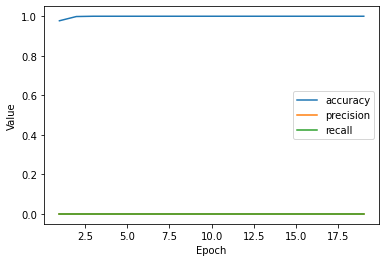

In [45]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
classification_threshold = 0.52
label_name = "median_house_value_is_high"

# Modify the following definition of METRICS to generate
# not only accuracy and precision, but also recall:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                      threshold=classification_threshold),
      tf.keras.metrics.Precision(thresholds=classification_threshold,
                                 name='precision' 
                                 ),
      tf.keras.metrics.Recall(name='recall',
                              thresholds=classification_threshold)
]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', 'precision', 'recall'] 
plot_curve(epochs, hist, list_of_metrics_to_plot)

Epoch 1/20
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
170/170 [==============================] - 0s 2ms/step - loss: 0.8520 - auc: 0.0000e+00
Epoch 2/20
170/170 [==============================] - ETA: 0s - loss: 0.7264 - auc: 0.0000e+0 - 0s 2ms/step - loss: 0.7161 - auc: 0.0000e+00
Epoch 3/20
170/170 [==============================] - 0s 2ms/step - loss: 0.5960 - auc: 0.0000e+00
Epoch 4/20
170/170 [==============================] - 0s 1ms/step - loss: 0.4934 - auc: 0.0000e+00
Epoch 5/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4091 - auc: 0.0000e+00A: 0s - loss: 0.4263 - auc: 0.0000e
Epoch 6/20
170/170 [==============================] - 0s 2ms/step - loss: 0.3421 - auc: 0.0000e+00A: 0s - loss: 0.3552 - auc: 0.0000e
Epoch 7/20
170/170 [==============================] - 0s 2ms/step - loss: 0.2895 - auc: 0.0000e+00
Epoch 8/20
170/170 [==============================] - 0s 2ms/step - loss: 0.2473 - au

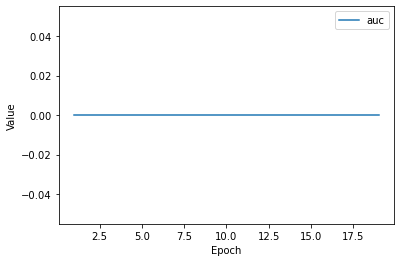

In [46]:
#@title Double-click to view the solution for Task 5.

# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
label_name = "median_house_value_is_high"

# AUC is a reasonable "summary" metric for 
# classification models.
# Here is the updated definition of METRICS to 
# measure AUC:
METRICS = [
      tf.keras.metrics.AUC(num_thresholds=100, name='auc'),
]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['auc'] 
plot_curve(epochs, hist, list_of_metrics_to_plot)